In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal, glorot_uniform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import zipfile
import pathlib
import glob
import os

In [2]:
print(tf.__version__)

2.15.0


<h3>Terminology</h3>

**A batch:**

- A *batch* is a small subset of the data. In the training process, rather than looking at all of the images at each iteration (note that in larger models, the whole dataset might be millions of images), our model looks at a small batch of images. Yann LeCun tweeted: "Training with large mini-batches is bad for your health. More importantly, it's bad for your **test error**. Friends don't let friends use mini-batches larger than 32."

**An epoch:**

- An *epoch* in the context of machine learning refers to one complete pass through the entire training dataset. In other words, an epoch consists of training the model on every sample in the training dataset. For example, if your training dataset has 10000 samples, an epoch means that the model has seen and processed all 10000 samples once. Five epochs would mean that the model has seen and processed the 10000 samples 5 times.

**Baseline model:**

- A *baseline model* is a simple model or an existing result that one sets up when beginning a machine learning experiment. The goal is to beat this baseline model with experimenting. In deep learning, there is almost infinite amount of architectures one could create. For this reason, one of the best ways to get started is to start with something simple and see if it works on your data, and just then introduce complexity to the model as required.

<h3>Breakdown of Conv2D layer</h3>

<table style="width:150%">
    <tr>
        <td style="text-align:center"> <b>Hyperparameter name</b> </td>
        <td style="text-align:center"> <b>What does it do?</b> </td>
        <td style="text-align:center"> <b>Typical values</b> </td>
    </tr>
    <tr>
        <td style="text-align:center">filters</td>
        <td style="text-align:center">Decides how many filters should pass over an input tensor. </td>
        <td style="text-align:center">10, 32, 64, 128 (higher values lead to more complex models)</td>
    </tr>
    <tr>
        <td style="text-align:center">kernel_size (a.ka.a. filter size)</td>
        <td style="text-align:center">Determines the shape of the filters (sliding "windows"). Larger kernel sizes tend to capture broader, less detailed patterns, potentially leading to less complex feature learning. Smaller kernel sizes focus on narrower segments of the input, allowing the model to learn more detailed and complex features.</td>
        <td style="text-align:center">3, 5, 7</td>
    </tr> 
    <tr>
        <td style="text-align:center">padding</td> 
        <td style="text-align:center">If "same", pads the target tensor with zeros to preserve input shape. If "valid", leaves the target tensor as it is.</td> 
        <td style="text-align:center">"same" or "valid"</td>
    </tr>
        <tr>
        <td style="text-align:center">strides</td>
        <td style="text-align:center">The number of steps (i.e., pixels) the filter moves over the input tensor after each iteration.</td>
        <td style="text-align:center">1 (default), 2</td>
    </tr>
</table>

<br>

<h3>Load in the data</h3>

In [3]:
# Unzip the file containing the images (it is located in the current wd)
zip_file_path = "pizza_steak.zip"
with zipfile.ZipFile(file=zip_file_path, mode="r") as zr:
    zr.extractall("pizza_steak_images")

- The **extractall** function will create a directory in the desired location with the desired name, and extract all the files from 'pizza_steak.zip' into it.

<h3>Exploring the dataset</h3>

In [4]:
# Looking inside the created directory
!ls pizza_steak_images/pizza_steak/train/pizza

1008104.jpg 1638227.jpg 2235981.jpg 2774899.jpg 3464027.jpg 576236.jpg
1008144.jpg 1646974.jpg 2236914.jpg 2775763.jpg 3464858.jpg 5764.jpg
1008844.jpg 1649108.jpg 2241448.jpg 2778214.jpg 3473991.jpg 579691.jpg
1008941.jpg 1649276.jpg 2247711.jpg 277963.jpg  3475936.jpg 593400.jpg
1011404.jpg 1652943.jpg 2253670.jpg 2785084.jpg 3478964.jpg 59445.jpg
102037.jpg  1654444.jpg 2255361.jpg 2793535.jpg 3479875.jpg 596494.jpg
1026922.jpg 1660415.jpg 2274117.jpg 27963.jpg   3479936.jpg 598381.jpg
1029698.jpg 1663749.jpg 2279642.jpg 2800325.jpg 3484590.jpg 604977.jpg
1033251.jpg 1665654.jpg 2280345.jpg 2811032.jpg 3493457.jpg 608085.jpg
1035854.jpg 166823.jpg  2285269.jpg 282013.jpg  349946.jpg  618021.jpg
1038357.jpg 1670471.jpg 2285942.jpg 2821034.jpg 350358.jpg  61822.jpg
1040878.jpg 1671531.jpg 228778.jpg  2821048.jpg 3505182.jpg 618348.jpg
1044524.jpg 1678284.jpg 2291093.jpg 2827938.jpg 3512070.jpg 625687.jpg
1044789.jpg 1681043.jpg 2292986.jpg 2831983.jpg 3514408.jpg 626170.jpg
1047561.jp

In [5]:
for dir_path, dir_names, file_names in os.walk("pizza_steak_images/pizza_steak"):
    if len(file_names) != 0:
        print(f"There are {len(file_names)} images in {dir_path}")

There are 250 images in pizza_steak_images/pizza_steak/test/steak
There are 250 images in pizza_steak_images/pizza_steak/test/pizza
There are 750 images in pizza_steak_images/pizza_steak/train/steak
There are 750 images in pizza_steak_images/pizza_steak/train/pizza


- Looks like the train and test folders contain a lot of images.

In [6]:
# Class names
data_dir = pathlib.Path("pizza_steak_images/pizza_steak")
class_names = [item.name for item in data_dir.glob(pattern="*")]

In [7]:
class_names

['test', 'train']

- Note that $\, "*" \,$ is a *wildcar* symbol, which means that any characters are accepted before and after the symbol.

In [8]:
[item.name for item in data_dir.glob(pattern="tr*")]

['train']

In [9]:
def view_random_img(img_dir, img_class):
    """
    Picks a random image from a given folder of a given class.

    Args:
    img_dir -- directory where the images are located
    img_class -- class of the img that you wish to visualize

    Returns:
    img -- a random image
    """
    img_folder = img_dir + img_class
    img_names_list = os.listdir(img_folder)
    
    # This returns a list with k elements, so we need to index it out
    random_image = random.sample(population=img_names_list, k=1)[0]
    
    # Read in the image using matplotlib.image
    img = imread(fname=img_folder + "/" + random_image)
    
    # Print the shape of the image
    print(f"Shape of the image: {img.shape}")
    
    # Plot the image
    plt.figure(figsize=(6,4), dpi=150)
    plt.title(img_class, size=12)
    plt.axis("off")
    plt.imshow(img);
    
    return img

Shape of the image: (384, 512, 3)


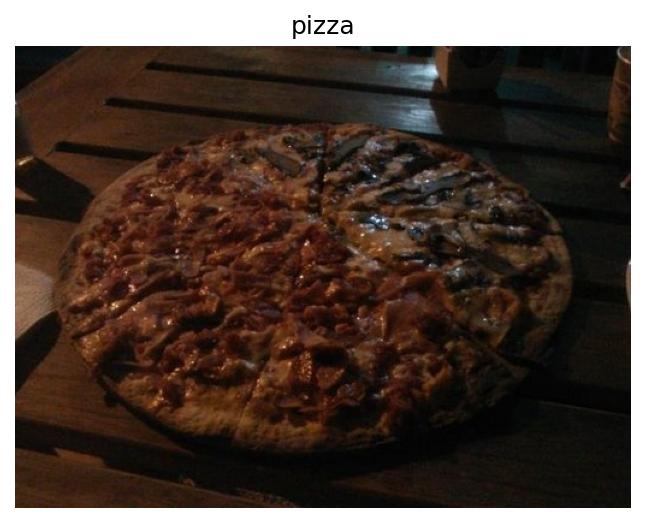

In [10]:
img = view_random_img("pizza_steak_images/pizza_steak/train/", "pizza")

In [11]:
img.shape

(384, 512, 3)

In [12]:
img.dtype

dtype('uint8')

In [13]:
img[:3, :3, :]

array([[[ 5, 14, 13],
        [ 7, 16, 15],
        [ 8, 17, 16]],

       [[ 4, 13, 12],
        [ 6, 15, 14],
        [ 7, 16, 15]],

       [[ 4, 13, 12],
        [ 5, 14, 13],
        [ 6, 15, 14]]], dtype=uint8)

- Inputs to the neural network will be these kinds of tensors, where the elements represents pixels of the image: (pixel_width, pixel_height, num_color_channels).
- The images are usually collapsed such that one image represents a column vector: $(\text{pixel_width} \, * \, \text{pixel_height} \, * \, \text{num_color_channels}, 1)$
- Note that the first column of $\, img \,$ corresponds to the red color channel, the second column corresponds to the green color channel, and the third column corresponds to the blue color channel.

In [14]:
# Collapse the image (tensor) into a column vector
reshaped_img = img.reshape(-1, 1)
reshaped_img.shape

(589824, 1)

NNs tend to perform better with normalized data. Let's normalize our image to have pixel values between 0 and 1. To do this, we divide all of the elements by the max value (pixel) of the image

In [15]:
max_val = float(np.max(reshaped_img))
img_reshaped_scaled = reshaped_img / max_val

In [16]:
print(f"Maximum value of the image: {max_val}")
print(f"Smallest value of the scaled image: {np.min(img_reshaped_scaled)}")
print(f"Largest value of the scaled image: {np.max(img_reshaped_scaled)}")

Maximum value of the image: 255.0
Smallest value of the scaled image: 0.0
Largest value of the scaled image: 1.0


- As said above, many ML models, including NNs, prefer to work with values between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also known as **normalizing**) the pixel values by dividing the image arrays by 255 (the maximum pixel value for a standard RGB image, where each color channel is represented by *8-bits*, is 255 (bit depth refers to the number of bits used to represent the color of a single pixel)).

<h3>Building a Convolutional Neural Network (CNN)</h3>

**1**. Load the images \
**2**. Preprocess the images \
**3**. Build a CNN to find patterns in the images \
**4**. Compile the CNN \
**5**. Fit the CNN to the training data \
**6**. Improve the model using the dev set (validation set)

In [17]:
tf.random.set_seed(42)

In [18]:
# Preprocess the images (scale the pixels to have values between 0 and 1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Directory paths (train and test sets)
train_dir = "pizza_steak_images/pizza_steak/train/"
valid_dir = "pizza_steak_images/pizza_steak/test/"

In [19]:
# Import the data from the train directory and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                                  batch_size=32,
                                                  target_size=(224, 224),
                                                  class_mode="binary",
                                                  seed=42)

Found 1500 images belonging to 2 classes.


In [20]:
# Import the data from the test directory and turn it into batches
valid_data = valid_datagen.flow_from_directory(directory=valid_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode="binary",
                                              seed=42)

Found 500 images belonging to 2 classes.


- **directory**: path to the directory containing the images.
- **batch_size**: controls the batch sizes in the training of the CNN. If for example batch_size=32, then 32 images will be loaded and processed at each iteration.
- **target_size**: reshapes all the images to this desired shape.
- **class_mode**: the number of classes we're working with.

Note that when we specify batch_size=32, we will have $\, k = \frac{\text{num_examples}}{32} \,$ batches of images, where each batch has 32 images. If the number of examples in the dataset is not divisible by the batch size, then the last batch will be smaller.

In [21]:
batch_size=32
num_steak_train_imgs = len(os.listdir(train_dir + "pizza"))
num_pizza_train_imgs = len(os.listdir(train_dir + "steak"))
total_train_imgs = num_steak_train_imgs + num_pizza_train_imgs
num_train_batches = int(np.round(total_train_imgs / batch_size))
print(f"Within our training data, we have {num_train_batches} batches.")

Within our training data, we have 47 batches.


In [22]:
# Verify that our training data indeed has 47 batches
len(train_data)

47

In [23]:
# Get a sample of train data batch
images, labels = train_data.next()    # Get the "next" batch of images/labels in train data

In [24]:
images.shape

(32, 224, 224, 3)

In [25]:
labels.shape

(32,)

- There is 32 images each of shape $\, (244, 244, 3), \,$ and 32 labels corresponding to these images (the labels tell whether the images are pizza or steak).

<h3>Building a baseline CNN model</h3>

- The **filters** argument in *Conv2D* function specifies how many fiters will convolve over the input with a $\, \text{width} \, x \, \text{height} \,$ window.
- The **kernel_size** argument in *Conv2D* function specifies the size of the *kernel* window (*filter*).
- The **strides** argument in *Conv2D* function specifies the stride length of the convolution. *Stride* refers to the number of pixels by which the filter window moves over the input matrix after each iteration. If the stride is set to 1 (default), the filters moves one pixel at a time over the input image. This means that the filter will be applied to overlapping regions of the input image (resulting in a larger *feature map*).
- **steps_per_epoch** argument in the *fit* function defines the total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch (the default 'None' is equal to the number of samples in your dataset divided by the batch size).
- **validation_steps** argument in the *fit* function defines the total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
- **pool_size** argument in the *MaxPool2D* function specifies the size of pooling "window". For example, if $\, \text{pool_size}=(2, 2), \,$ then at each iteration, the maximum element is selected from a "window" of size $\, 2x2.$

For example, if $\, \text{filters}=10 \,$ and $\, \text{kernel_size}=(3,3), \,$ this means that 10 different filters will convolve over the input with a $\, 3x3 \,$ window, producing 10 different *feature maps* that help in extracting local patterns and features from the input data.

In [26]:
def baseline_model(Train_data, Val_data, num_epochs):

    # Architecture of the CNN model
    model = tf.keras.models.Sequential([

        # Input layer
        tf.keras.layers.Input(shape=(224, 224, 3), name="Baseline model"),

        # Hidden layer 1
        tf.keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3),
                               activation="relu"),

        # Flatten the output of hidden layer 1 into a 1D vector
        # (in this case, the output layer requires 1D vector as an input)
        tf.keras.layers.Flatten(),

        # Output layer
        tf.keras.layers.Dense(units=1, activation="sigmoid")
    ])

    # Compile the CNN model
    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=["accuracy"])

    # Fit the model
    loss_history = model.fit(Train_data,
                             epochs=num_epochs,
                             steps_per_epoch=len(Train_data),
                             validation_data=Val_data,
                             validation_steps=len(Val_data))
    
    def plot_learning_curve(loss_history):
        fig, ax = plt.subplots(figsize=(8,6), dpi=100)
        ax.plot(np.arange(1, num_epochs+1), 
                loss_history.history["loss"], 
                color="red",
                linestyle="--",
                label="training loss")
        ax.plot(np.arange(1, num_epochs+1),
                loss_history.history["val_loss"],
                color="blue",
                label="validation loss")
        ax.set_title("Learning curve", size=12)
        ax.set_xlabel("Number of epochs", size=12)
        ax.set_ylabel("Cost function value", size=12)
        plt.legend();
        
    plot_learning_curve(loss_history)
    
    return model, loss_history

Epoch 1/5
47/47 [==============================] - 4s 91ms/step - loss: 3.3723 - accuracy: 0.6827 - val_loss: 1.2471 - val_accuracy: 0.5780
Epoch 2/5
47/47 [==============================] - 4s 88ms/step - loss: 0.6154 - accuracy: 0.7647 - val_loss: 0.4405 - val_accuracy: 0.8020
Epoch 3/5
47/47 [==============================] - 4s 89ms/step - loss: 0.2862 - accuracy: 0.9020 - val_loss: 0.4495 - val_accuracy: 0.7960
Epoch 4/5
47/47 [==============================] - 4s 90ms/step - loss: 0.2029 - accuracy: 0.9333 - val_loss: 0.4146 - val_accuracy: 0.8100
Epoch 5/5
47/47 [==============================] - 4s 90ms/step - loss: 0.1064 - accuracy: 0.9767 - val_loss: 0.4443 - val_accuracy: 0.8100


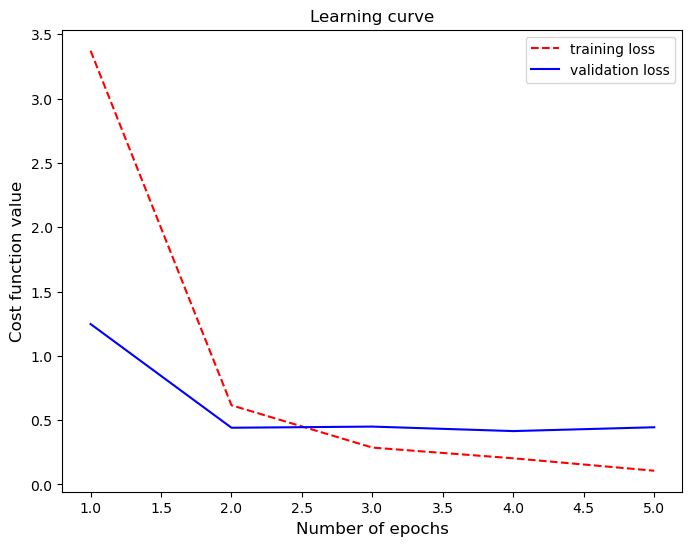

In [27]:
base_model, base_model_loss_history = baseline_model(train_data, valid_data, num_epochs=5)

<h3>A quick note on neurons</h3>

A neuron can be thought of as a function that takes in multiple inputs and yields a single output. Described more mathematically, a neuron is a function that takes in multiple inputs, performs linear transformation on those inputs and their corresponding weights using dot product, adds a bias to the dot product output, and finally, adds a non-linearity to the shifted linear transformation. With mathematical notation, the operator inside a neuron can be represented as follows:

\begin{align*}
    g(WX \, + \, b),
\end{align*}

where $\, WX \,$ is the dot product between the inputs $\, X \,$ and their corresponding weights $\, W, \,$ $\, b \,$ is the bias that shifts the linear transformation, and $\, g() \,$ is the non-linear activation function that is applied to the shifted linear transformation.

Some clarification on the used terminology:

- **Inputs** ($X$): these are the features or "signals" received by the neuron.
- **Weights** ($W$): these are the parameters that determine the importance of each input (each input has a corresponding weight).
- **Bias** ($b$): this is an additional parameter that allows the activation function $\, g() \,$ to be shifted.

Note that the dot product is just a weighted sum between the inputs $X$ and their corresponding weights $W$:

\begin{align*}
    \sum_{i=1}^{n} X_i \, \cdot \, W_i
\end{align*}

Note that the **layers** of a neural network are just a collection of neurons with the same **operation**, including the same *hyperparameters*. Note that *hidden layers* refers to any layers between the input layer and the output layer of a neural network.

For more information, see: https://poloclub.github.io/cnn-explainer/

<h3>A quick note on max pooling</h3>

Max pooling is a technique used to reduce the dimensionality of the *activation maps*. Max pooling helps by reducing the computational complexity, controlling overfitting, and summarizing the most important features detected by the convolutional layers.

<br>

The sequence of operations in a CNN is as follows:

1. **Convolution operation**: convolutional layers apply *kernels* (*filters*) to the input data (or previous layer's output), producing intermediate *feature maps*.

2. **Activation function**: non-linear activation functions (e.g., ReLU) are applied to these feature maps, resulting in what are commonly referred to as *activation maps*.

3. **Max pooling**: the max pooling operation is applied to these activation maps, effectively reducing their spatial dimensions.

<br>

Let's examine the sequence of operations in a CNN with an illustrative example. Suppose that our input matrix is:

<br>
\begin{bmatrix}
    1 & 2 & 3 & 4 \\
    5 & 6 & 7 & 8 \\
    9 & 10 & 11 & 12 \\
    13 & 14 & 15 & 16 \\
\end{bmatrix}
<br>

**Step 1**. Apply convolution operation with a $\, 2x2 \,$ filter. The filter could look as follows:

<br>
\begin{bmatrix}
    0 & 2 \\
    4 & 1
\end{bmatrix}
<br>

This filter is moved through the whole input matrix (according to the *stride* value) such that it covers every part of it, producing a *feature map*. A single element of the feature map is an element-wise multiplication and summation of the filter values and the input matrix values that they are currently "sitting"  on (i.e., the part of the input matrix that the $\, 2x2 \,$ filter currently covers). For example, a single element of the feature map, starting from the top left, would be:

<br>
$$
\begin{bmatrix}
1 & 2 \\
5 & 6
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 30
$$
<br>

*Stride* indicates how many pixels the filter should be shifted over at a time. Suppose our stride value is 1. Then, we would move one pixel to the right to perform the next element-wise multiplication and summation:

<br>
$$
\begin{bmatrix}
2 & 3 \\
6 & 7
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 37
$$
<br>

We continue this until we have covered all the parts of the input matrix:

<br>
$$
\begin{bmatrix}
3 & 4 \\
7 & 8
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 44
$$
<br>

<br>
$$
\begin{bmatrix}
5 & 6 \\
9 & 10
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 58
$$
<br>

<br>
$$
\begin{bmatrix}
6 & 7 \\
10 & 11
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 65
$$
<br>

<br>
$$
\begin{bmatrix}
7 & 8 \\
11 & 12
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 72
$$
<br>

<br>
$$
\begin{bmatrix}
9 & 10 \\
13 & 14
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 86
$$
<br>

<br>
$$
\begin{bmatrix}
10 & 11 \\
14 & 15
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 93
$$
<br>

<br>
$$
\begin{bmatrix}
11 & 12 \\
15 & 16
\end{bmatrix}
\,
\cdot
\,
\begin{bmatrix}
0 & 2 \\
4 & 1
\end{bmatrix}
= 100
$$
<br>

Putting these together gives us the *feature map*:

<br>
\begin{align*}
\text{Feature map} =
\begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix}
\end{align*}
<br>

**Step 2**: Apply the non-linear activation function (ReLU) to obtain the *activation map*. $\, ReLU(z) = \text{max}(0, z). \,$ Notice that the ReLU is applied element-wise to every element in the feature map.

<br>
\begin{align*}
    \text{Activation map}=
    ReLU \left(\begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix} \right) = \begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix}
\end{align*}
<br>

**Step 3**: Max pooling operation $\, (2x2) \,$ with a stride of 1. This means that we slide the $\, (2x2) \,$ "window" through the *activation map* one pixel at a time such that every part gets covered, and with each iteration, select the maximum value out of that "window". This effectively reduces the spatial dimension of the activation map. In tensorflow, the size of the "window" is specified with the **pool_size** argument.

<br>
\begin{align*}
    \text{Reduced activation map}=
    \text{MaxPool} \left(\begin{bmatrix}
    30 & 37 & 44 \\
    58 & 65 & 72 \\
    86 & 93 & 100
\end{bmatrix} \right) = \begin{bmatrix}
    65 & 72  \\
    93 & 100
\end{bmatrix}
\end{align*}
<br>

**Summary**:

- Starting from the input image, we applied a $\, 2x2 \,$ kernel (filter) to perform convolution, followed by the ReLU activation function. Afterward, we applied a $\, 2x2 \,$ max pooling operation with a stride of 1, resulting in a $\, 2x2 \,$ output activation map that retains the most prominent features from the original input. This process effectively reduces the spatial dimensions while retaining the most significant values from each pooling region.

<h3>A quick note on filters</h3>

In the example above, we went through one filter. In reality (like in the model we specified earlier), there is going to be multiple different filters. Suppose your input matrix is of shape $\, (4, 4), \,$ and you apply a filter of shape $\, (2, 2) \,$ to it (*kernel_size* specifies the size of the filter) with a stride of 1, and no padding (*padding*="valid" means no padding is added to the input matrix after the convolutional layer has most likely reduced its size). Then, the output matrix will be of shape $\, (3, 3) \,$ (see the example above to understand why). Notice that the convolutional layer has effectively reduced the size of the input matrix. However, this is just one filter. If we specify $\, \text{filters}=10 \,$ (like in the example above), it means that we are using $\, 10 \,$ different filters of shape $\, (2, 2). \,$ Each filter produces its own output matrix of shape $\, (3, 3). \,$ These $\, 10 \,$ output matrices are then stacked together to form the final output matrix that will be passed on to the next layer as an input.

<h3>Improving the baseline CNN model</h3>

Main steps when building any machine learning models:

**1**. Become one with the data (e.g., visualize) \
**2**. Preprocess the data (e.g., scale, turn everything into numerical values) \
**3**. Create a baseline model \
**4**. Fit the model \
**5**. Evaluate the model's performance \
**6**. Adjust different parameters and hyperparameters to improve the model (try to beat the baseline model) \
**7**. Repeat until satisfied with the final model

One way to try to beat the baseline is to purposely overfit the model to the training data, and see where the validation performance starts to deviate from the training performance, and then try to reduce this overfitting.

Some ways to increase overfitting:

- Increase the number of the layers (make the model deeper) 
- Increse the number of filters in conv layers or units in dense layers.

Some ways to reduce overfitting:

- Add data augmentation
- Add regularization (L2, Dropout, maxpool, etc.)
- Add more data

In [34]:
def model_1(Train_data, Val_data, num_epochs):
    # Architecture of the model
    model = Sequential([
        
        Input(shape=(224,224,3), name="model_1"),
        
        Conv2D(filters=10, 
               kernel_size=(3,3), 
               activation="relu",
               strides=(1,1),
               padding="valid",
               kernel_initializer=he_normal()),
        
        Conv2D(filters=10, 
               kernel_size=(3,3), 
               activation="relu",
               strides=(1,1),
               padding="valid",
               kernel_initializer=he_normal()),
        
        MaxPool2D(pool_size=(2,2), strides=(1,1)),
        
        Flatten(),
        
        Dense(units=50,
              kernel_initializer=he_normal(),
              activation="relu"),
        
        Dense(units=50,
              kernel_initializer=he_normal(),
              activation="relu"),
        
        Dense(1, kernel_initializer=glorot_uniform(), activation="sigmoid")        
    ])
    # Compile the model
    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.legacy.Adam(),
                  metrics=["accuracy"])
    # Fit the model
    loss_history = model.fit(Train_data,
                             epochs=num_epochs,
                             steps_per_epoch=len(Train_data),
                             validation_data=Val_data,
                             validation_steps=len(Val_data))
    
    def plot_learning_curve(loss_history):
        fig, ax = plt.subplots(figsize=(8,6), dpi=100)
        ax.plot(np.arange(1, num_epochs+1), 
                loss_history.history["loss"], 
                color="red",
                linestyle="--",
                label="training loss")
        ax.plot(np.arange(1, num_epochs+1),
                loss_history.history["val_loss"],
                color="blue",
                label="validation loss")
        ax.set_title("Learning curve", size=12)
        ax.set_xlabel("Number of epochs", size=12)
        ax.set_ylabel("Cost function value", size=12)
        plt.legend();
        
    plot_learning_curve(loss_history)
    
    return model, loss_history

Epoch 1/5
47/47 [==============================] - 16s 333ms/step - loss: 3.4675 - accuracy: 0.6873 - val_loss: 0.6706 - val_accuracy: 0.7260
Epoch 2/5
47/47 [==============================] - 16s 342ms/step - loss: 0.3647 - accuracy: 0.8480 - val_loss: 0.5250 - val_accuracy: 0.7800
Epoch 3/5
47/47 [==============================] - 17s 359ms/step - loss: 0.1853 - accuracy: 0.9340 - val_loss: 0.4062 - val_accuracy: 0.8380
Epoch 4/5
47/47 [==============================] - 18s 391ms/step - loss: 0.0709 - accuracy: 0.9873 - val_loss: 0.4772 - val_accuracy: 0.8180
Epoch 5/5
47/47 [==============================] - 21s 442ms/step - loss: 0.0454 - accuracy: 0.9947 - val_loss: 0.5103 - val_accuracy: 0.8120


(<keras.src.engine.sequential.Sequential at 0x326a337d0>,
 <keras.src.callbacks.History at 0x3269c5b10>)

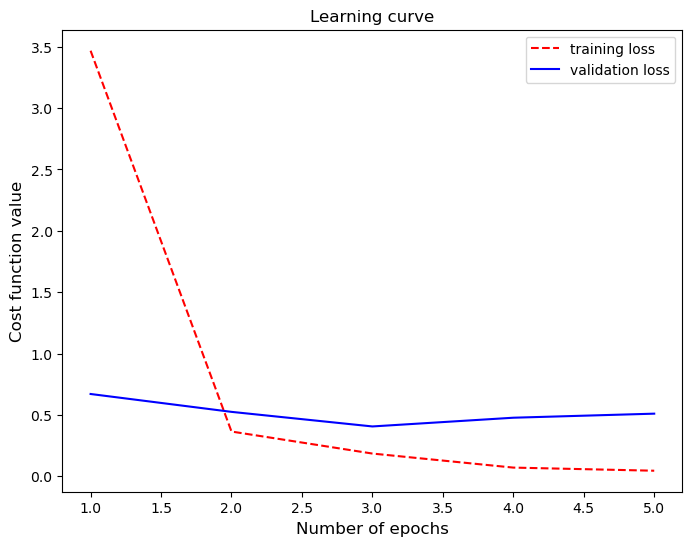

In [35]:
model_1(train_data, valid_data, num_epochs=5)